# Workflow Advance Configuration(MNIST Inference)

****Advance Configuration****: 


| Configuration | level | details |
| :---- | :---- | :---- |
| resource requirement | workflow | K8s V1Affinity: Affinity sets the scheduling constraints for all nodes in the io.argoproj.workflow.v1alpha1. Can be overridden by an affinity specified in the node
|  | node(executor) | K8s V1ResourceRequirements: resource limits for a executor
|  |  | K8s V1Affinity: Affinity sets the scheduling constraints for a executor
|  | node(service) | K8s V1ResourceRequirements: resource limits for a service
|  | | K8s V1Affinity: Affinity sets the scheduling constraints for a service
| scaler | workflow | KedaScaler |

- *Steps*
    1. Import Scanflow and check the local environment
    2. Develop scanflow application (workflows)
    3. Build scanflow application
    4. Deploy scanflow environment
    5. Download production models
    6. Submit the metadata and artifacts to the central Scanflow-tracker
    7. ****[Inference]****
        1. Batch-inference (Argo)
        2. Online-inference (Seldon)
    8. Clean environment

## Steps
### Step1: Import Scanflow and check the local environment
1. import scanflow
    - For defining and building scanflow application, we need to import ScanflowClient
    - For deploying scanflow application, we need to import ScanflowDeployerClient
    - For saving artifacts, we need to import ScanflowTrackerClient
2. check local environment
    - For deploying scanflow application
        - If user starts the notebook at local and has the privilege to submit object on Kubernetes. We don't need to configure "SCANFLOW_SERVER_URI"
        - If user starts the notebook inside Kubernetes pod, or the local user does not have privilege to connect Kubernetes. We need to configure "SCANFLOW_SERVER_URI"
    - For saving deliverables, we need to configure url of Scanflow-tracker on "SCANFLOW_TRACKER_URI" and url of Scanflow-local-tracker on "SCANFLOW_TRACKER_LOCAL_URI"
    - If Scanflow-tracker is using S3 artifact storage, we need to configure S3 url "MLFLOW_S3_ENDPOINT_URL", username "AWS_ACCESS_KEY_ID" and password "AWS_SECRET_ACCESS_KEY"

In [1]:
import sys
import os
sys.path.insert(0,'../..')

import scanflow
from scanflow.client import ScanflowClient
from scanflow.client import ScanflowTrackerClient
from scanflow.client import ScanflowDeployerClient

In [2]:
from scanflow.tools import env
print(env.get_env("SCANFLOW_SERVER_URI"))
print(env.get_env("SCANFLOW_TRACKER_URI"))
#print(env.get_env("SCANFLOW_TRACKER_LOCAL_URI"))
print(env.get_env("MLFLOW_S3_ENDPOINT_URL"))
print(env.get_env("AWS_ACCESS_KEY_ID"))
print(env.get_env("AWS_SECRET_ACCESS_KEY"))

http://172.30.0.50:46666
http://172.30.0.50:46667
http://172.30.0.50:43447
admin
admin123


### Step2: Develop scanflow application

  1. develop component (requirement.txt, script.py)
  2. define scanflow workflows (Executor, Dependency, Workflow)
  3. define agents to supervise the workflows
  4. define scanflow application
  ```bash
     Application
        - List: Workflow(DAG)
                  - List: Executor, Service
                  - List: Dependency
  ```
  
  
     For example:
     
  ```bash
  mnist
    - workflows
       - load_data
         - loaddata.py
       - predictor-batch
         - predictor.py
```


#### 2.1. Develop scanflow workflows

In [3]:
# App folder
scanflow_path = "/gpfs/bsc_home/xpliu/pv/jupyterhubpeini/scanflow"
app_dir = os.path.join(scanflow_path, "examples/mnist/dataengineer")
app_name = "mnist"
team_name = "dataengineer"

# scanflow client
client = ScanflowClient(
              #if you defined "SCANFLOW_SERVER_URI", you dont need to provide this
              #scanflow_server_uri="http://172.30.0.50:46666",
              verbose=True)

In [4]:
#resource requirment
resources = client.V1ResourceRequirements(requests={'cpu': '500m', 'memory': '1Gi'},
                                          limits={'cpu': '500m', 'memory': '1Gi'})

#affinity
# https://kubernetes.io/docs/concepts/scheduling-eviction/assign-pod-node/#affinity-and-anti-affinity
node_selector_batch = client.V1NodeSelectorTerm(
                         match_expressions=[
                             client.V1NodeSelectorRequirement(
                                 key = 'scheduler',
                                 operator = 'In',
                                 values = ['batch']
                             )
                         ]
              )

node_selector_service = client.V1NodeSelectorTerm(
                         match_expressions=[
                             client.V1NodeSelectorRequirement(
                                 key = 'scheduler',
                                 operator = 'In',
                                 values = ['service']
                             )
                         ]
              )

node_selector_batch = client.V1NodeSelector(node_selector_terms=[node_selector_batch])
node_selector_service = client.V1NodeSelector(node_selector_terms=[node_selector_service])

node_affinity_batch = client.V1NodeAffinity(
    required_during_scheduling_ignored_during_execution=node_selector_batch)
node_affinity_service = client.V1NodeAffinity(
    required_during_scheduling_ignored_during_execution=node_selector_service)

affinity_batch = client.V1Affinity(node_affinity=node_affinity_batch)
affinity_service = client.V1Affinity(node_affinity=node_affinity_service)


#keda scaler
trigger_request_rate = client.ScalerTriggerPrometheus(
        serverAddress = 'http://prometheus.istio-system:9090',
        metricName = 'istio_requests_total',
        query = 'sum(irate(istio_requests_total{connection_security_policy="mutual_tls",destination_service=~"online-inference-online-inference.scanflow-mnist-dataengineer.svc.cluster.local",reporter="destination",destination_workload=~"online-inference-online-inference-0-predictor-online",destination_workload_namespace=~"scanflow-mnist-dataengineer"}[5m]))',
        threshold = 1,
)

kedaSpec = client.KedaSpec(maxReplicaCount=5,
                           minReplicaCount=1,
                           pollingInterval=10,
                           cooldownPeriod=10,
                           triggers=[trigger_request_rate])

In [5]:
#predictor
executor1 = client.ScanflowExecutor(name='load-data', 
                      mainfile='loaddata.py',
                      parameters={'app_name': app_name,
                                  'team_name': 'data'},
                      resources=resources)

executor2 = client.ScanflowExecutor(name='predictor-batch', 
                      mainfile='predictor.py',
                      parameters={'model_name': 'mnist_cnn',
                                  'input_data': '/workflow/load-data/mnist/data/mnist_sample/test_images.npy', },
                      base_image='modeling-cnn1',
                      resources=resources)


dependency1 = client.ScanflowDependency(dependee='load-data',
                                    depender='predictor-batch')

##workflow1 batch-inference
## -- load_data
##       -- predictor-batch
workflow1 = client.ScanflowWorkflow(name='batch-inference', 
                     nodes=[executor1, executor2],
                     edges=[dependency1],
                     affinity = affinity_batch,
                     output_dir = "/workflow")
              

In [6]:
#predictor online
service = client.ScanflowService(name='predictor-online',
                                 implementation_type = 'TENSORFLOW_SERVER',
                                 modelUri = 's3://scanflow/scanflow-mnist-dataengineer/1/d41424882d314d048c611b7e84960c8e/artifacts/mnist-tf/model',
                                 envSecretRefName = 'scanflow-secret',
                                 endpoint = {'type': 'GRPC'},
                                 parameters=[{'name': 'model_name', 'type':'STRING', 'value':'predictor-online'},
                                             {'name': 'model_input', 'type':'STRING', 'value':'input_1'},
                                             {'name': 'model_output', 'type':'STRING', 'value':'dense_1'}],
                                 resources=resources
                                )

##workflow2 online-inference
##       -- predictor-online
workflow2 = client.ScanflowWorkflow(name='online-inference', 
                     nodes=[service],
                     affinity = affinity_service,
                     kedaSpec = kedaSpec,
                     output_dir = "/workflow")

#### 2.3. Define scanflow application

In [7]:
app = client.ScanflowApplication(app_name = app_name,
                                 app_dir = app_dir,
                                 team_name = team_name,
                                 workflows=[workflow1, workflow2])

In [8]:
dic = app.to_dict()

15-Sep-21 15:20:15 -  INFO - workflow batch-inference: {'name': 'batch-inference', 'nodes': [{'name': 'load-data', 'node_type': 'executor', 'mainfile': 'loaddata.py', 'parameters': {'app_name': 'mnist', 'team_name': 'data'}, 'requirements': None, 'dockerfile': None, 'base_image': None, 'env': None, 'image': {'limits': {'cpu': '500m', 'memory': '1Gi'},
 'requests': {'cpu': '500m', 'memory': '1Gi'}}, 'resources': None, 'affinity': None}, {'name': 'predictor-batch', 'node_type': 'executor', 'mainfile': 'predictor.py', 'parameters': {'model_name': 'mnist_cnn', 'input_data': '/workflow/load-data/mnist/data/mnist_sample/test_images.npy'}, 'requirements': None, 'dockerfile': None, 'base_image': 'modeling-cnn1', 'env': None, 'image': {'limits': {'cpu': '500m', 'memory': '1Gi'},
 'requests': {'cpu': '500m', 'memory': '1Gi'}}, 'resources': None, 'affinity': None}], 'edges': [{'depender': 'predictor-batch', 'dependee': 'load-data', 'edge_type': 'dependency', 'priority': 0}], 'affinity': {'node_af

  
### Step3: Build scanflow application (local)
   
  1. build images for Executor -> save to image registry



In [9]:
build_app = client.build_ScanflowApplication(app = app, trackerPort=46669)

15-Sep-21 15:20:18 -  INFO - Building image 172.30.0.49:5000/load-data
15-Sep-21 15:20:18 -  INFO - Building image 172.30.0.49:5000/predictor-batch
15-Sep-21 15:20:18 -  INFO - Building image 172.30.0.49:5000/predictor-online
15-Sep-21 15:20:18 -  INFO - [+] Image [172.30.0.49:5000/predictor-online] not found in repository. Building a new one.
15-Sep-21 15:20:18 -  INFO - [+] Dockerfile: [Dockerfile_scanflow_service] was not created.
15-Sep-21 15:20:18 -  INFO - dockerfile for using None from /gpfs/bsc_home/xpliu/pv/jupyterhubpeini/scanflow/examples/mnist/dataengineer/workflows


In [10]:
build_app.to_dict()

15-Sep-21 15:20:22 -  INFO - workflow batch-inference: {'name': 'batch-inference', 'nodes': [{'name': 'load-data', 'node_type': 'executor', 'mainfile': 'loaddata.py', 'parameters': {'app_name': 'mnist', 'team_name': 'data'}, 'requirements': None, 'dockerfile': None, 'base_image': None, 'env': None, 'image': '172.30.0.49:5000/load-data:latest', 'resources': None, 'affinity': None}, {'name': 'predictor-batch', 'node_type': 'executor', 'mainfile': 'predictor.py', 'parameters': {'model_name': 'mnist_cnn', 'input_data': '/workflow/load-data/mnist/data/mnist_sample/test_images.npy'}, 'requirements': None, 'dockerfile': None, 'base_image': 'modeling-cnn1', 'env': None, 'image': '172.30.0.49:5000/predictor-batch:latest', 'resources': None, 'affinity': None}], 'edges': [{'depender': 'predictor-batch', 'dependee': 'load-data', 'edge_type': 'dependency', 'priority': 0}], 'affinity': {'node_affinity': {'preferred_during_scheduling_ignored_during_execution': None,
                   'required_durin

{'app_name': 'mnist',
 'app_dir': '/gpfs/bsc_home/xpliu/pv/jupyterhubpeini/scanflow/examples/mnist/dataengineer',
 'team_name': 'dataengineer',
 'workflows': [{'name': 'batch-inference',
   'nodes': [{'name': 'load-data',
     'node_type': 'executor',
     'mainfile': 'loaddata.py',
     'parameters': {'app_name': 'mnist', 'team_name': 'data'},
     'requirements': None,
     'dockerfile': None,
     'base_image': None,
     'env': None,
     'image': '172.30.0.49:5000/load-data:latest',
     'resources': None,
     'affinity': None},
    {'name': 'predictor-batch',
     'node_type': 'executor',
     'mainfile': 'predictor.py',
     'parameters': {'model_name': 'mnist_cnn',
      'input_data': '/workflow/load-data/mnist/data/mnist_sample/test_images.npy'},
     'requirements': None,
     'dockerfile': None,
     'base_image': 'modeling-cnn1',
     'env': None,
     'image': '172.30.0.49:5000/predictor-batch:latest',
     'resources': None,
     'affinity': None}],
   'edges': [{'depend

### Step4: Deploy scanflow environment (local/incluster)
  
  1. Create k8s environment
        - create namespace
        - create RBAC, secret, configmap, PV, PVC
        
  2. Deploy scanflow-local-tracker (deployment, service)

       

In [13]:
deployerClient = ScanflowDeployerClient(user_type="local",
                                        deployer="seldon",
                                        k8s_config_file="/gpfs/bsc_home/xpliu/.kube/config")

15-Sep-21 15:22:00 -  INFO - loading kubernetes configuration from /gpfs/bsc_home/xpliu/.kube/config
15-Sep-21 15:22:00 -  INFO - found local kubernetes configuration


In [20]:
await deployerClient.create_environment(app=build_app)

15-Sep-21 15:32:25 -  INFO - [++]Creating env
15-Sep-21 15:32:25 -  INFO - [++]Creating namespace "scanflow-mnist-dataengineer"
15-Sep-21 15:32:26 -  ERROR - create_namespace error
15-Sep-21 15:32:26 -  INFO - [++]Creating Role for 'default service account'
15-Sep-21 15:32:26 -  ERROR - create_rolebinding error
15-Sep-21 15:32:26 -  INFO - [++]Creating s3 secret {'AWS_ACCESS_KEY_ID': 'admin', 'AWS_SECRET_ACCESS_KEY': 'admin123', 'MLFLOW_S3_ENDPOINT_URL': 'http://minio.minio-system.svc.cluster.local:9000', 'AWS_ENDPOINT_URL': 'http://minio.minio-system.svc.cluster.local:9000'}


ApiException: (403)
Reason: Forbidden
HTTP response headers: HTTPHeaderDict({'Cache-Control': 'no-cache, private', 'Content-Type': 'application/json', 'Date': 'Wed, 15 Sep 2021 13:32:26 GMT', 'Content-Length': '454'})
HTTP response body: {"kind":"Status","apiVersion":"v1","metadata":{},"status":"Failure","message":"secrets \"scanflow-secret\" is forbidden: unable to create new content in namespace scanflow-mnist-dataengineer because it is being terminated","reason":"Forbidden","details":{"name":"scanflow-secret","kind":"secrets","causes":[{"reason":"NamespaceTerminating","message":"namespace scanflow-mnist-dataengineer is being terminated","field":"metadata.namespace"}]},"code":403}



### Step5: download prepared production mnist model
   - download mnist-checker model (e.g., mnist_detector)
   - download mnist model (e.g., mnist_cnn)            


In [17]:
trackerClient = ScanflowTrackerClient(scanflow_tracker_local_uri="http://172.30.0.50:46669",
                        verbose=True)

In [18]:
trackerClient.download_app_model(model_name="mnist_cnn")

09-Jun-21 10:21:32 -  INFO - Found credentials in environment variables.
09-Jun-21 10:21:33 -  INFO - mnist--scanflow-model-datascience--{'training_dataset_len': 60000.0, 'accuracy': 0.9}--{}
09-Jun-21 10:21:34 -  INFO - mnist_cnn exists
2021/06/09 10:21:34 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: mnist_cnn, version 9


In [46]:
trackerClient.download_app_model(model_name="mnist-tf")

10-Jun-21 11:15:23 -  INFO - Found credentials in environment variables.
10-Jun-21 11:15:24 -  INFO - mnist--scanflow-model-datascience--{'loss': 1.5987423658370972, 'sparse_categorical_accuracy': 0.5139076113700867, 'val_loss': 0.5347447395324707, 'val_sparse_categorical_accuracy': 0.8608940839767456}--{'epochs': '10', 'steps_per_epoch': '58', 'validation_steps': '9', 'validation_freq': '1', 'batch_size': 'None', 'validation_split': '0.0', 'shuffle': 'True', 'class_weight': 'None', 'sample_weight': 'None', 'initial_epoch': '0', 'validation_batch_size': 'None', 'max_queue_size': '10', 'workers': '1', 'use_multiprocessing': 'False', 'opt_name': 'SGD', 'opt_learning_rate': "{'class_name': 'ExponentialDecay', 'config': {'initial_learning_rate': 0.05, 'decay_steps': 100000, 'decay_rate': 0.96, 'staircase': False, 'name': None}}", 'opt_decay': '0.0', 'opt_momentum': '0.0', 'opt_nesterov': 'False'}
10-Jun-21 11:15:25 -  INFO - mnist-tf exists
2021/06/10 11:15:25 INFO mlflow.tracking._model_r

### Step6: Submit the metadata and artifacts to the central Scanflow-tracker

  #### 6.1. Submit scanflowapp metadata
  ```bash
   mnist
    - dataengineer
     - workflows
        - batch-inference.json
        - detector-inference.json
     - mnist.json
  ```

In [18]:
trackerClient = ScanflowTrackerClient(scanflow_tracker_local_uri="http://172.30.0.50:46669",
                        verbose=True)

In [19]:
trackerClient.save_app_meta(build_app)

14-Jun-21 23:06:03 -  INFO - Connecting tracking server uri: http://172.30.0.50:46667
14-Jun-21 23:06:03 -  INFO - save app to artifact uri: s3://scanflow/1/09dbc72504584286802a914e2f70ac36/artifacts
14-Jun-21 23:06:03 -  INFO - Scanflowagent-tracker: {'name': 'tracker', 'template': 'monitor', 'sensors': [{'name': 'count_number_of_predictions', 'isCustom': True, 'func_name': 'count_number_of_predictions', 'trigger': {'weeks': 0, 'days': 0, 'hours': 1, 'minutes': 0, 'seconds': 0, 'start_date': None, 'end_date': None, 'timezone': None, 'jitter': None}, 'args': None, 'kwargs': None, 'next_run_time': None}], 'dockerfile': None, 'image': '172.30.0.49:5000/tracker-agent:latest'}
14-Jun-21 23:06:03 -  INFO - Scanflowagent-checker: {'name': 'checker', 'template': 'analyzer', 'sensors': [{'name': 'count_number_of_newdata', 'isCustom': True, 'func_name': 'count_number_of_newdata', 'trigger': {'weeks': 0, 'days': 0, 'hours': 1, 'minutes': 0, 'seconds': 0, 'start_date': None, 'end_date': None, 'ti

#### 6.2. Submit artifacts

  ```bash
mnist
    - workflows
       - load_data
         - loaddata.py
       - predictor-batch
         - predictor.py
       - predictor-online
```


In [20]:
trackerClient.save_app_artifacts(app_name=app_name, 
                                team_name=team_name, 
                                app_dir=app_dir)

14-Jun-21 23:06:08 -  INFO - Connecting tracking server uri: http://172.30.0.50:46667
14-Jun-21 23:06:08 -  INFO - save app in /gpfs/bsc_home/xpliu/pv/jupyterhubpeini/scanflow/examples/mnist/dataengineer to artifact uri: s3://scanflow/1/c5639371ccf6485b9e3618e788169932/artifacts


### Step7: ****[Inference]****

#### 7.1. Batch Inference

Batch worklflow(workflow[0]:batch-inference) is defined by dataengineer, client could use it by changing the parameters.

Below simulate the client makes predictions by using default parameters

In [16]:
await deployerClient.run_workflow(app_name='mnist', 
                                  team_name='dataengineer',
                                  workflow = build_app.workflows[0])

25-May-21 15:58:22 -  INFO - [+] output dir /workflow
25-May-21 15:58:22 -  INFO - [+] Create batch-inference output PV
25-May-21 15:58:22 -  INFO - create_pv true
25-May-21 15:58:22 -  INFO - [+] Create batch-inference output PVC
25-May-21 15:58:22 -  INFO - create_pvc true
25-May-21 15:58:22 -  INFO - output dir created
25-May-21 15:58:22 -  INFO - env for executor {'AWS_ACCESS_KEY_ID': 'admin', 'AWS_SECRET_ACCESS_KEY': 'admin123', 'MLFLOW_S3_ENDPOINT_URL': 'http://minio.minio-system.svc.cluster.local:9000', 'SCANFLOW_TRACKER_URI': 'http://scanflow-tracker-service.scanflow-system.svc.cluster.local', 'SCANFLOW_SERVER_URI': 'http://scanflow-server-service.scanflow-system.svc.cluster.local', 'SCANFLOW_TRACKER_LOCAL_URI': 'http://scanflow-tracker.scanflow-mnist-dataengineer.svc.cluster.local'}
25-May-21 15:58:22 -  INFO - [+] Building workflow: [batch-inference:load-data].
25-May-21 15:58:22 -  INFO - ['--app_name', 'mnist', '--team_name', 'data']
25-May-21 15:58:22 -  INFO - [+] Buildin

OrderedDict([('apiVersion', 'argoproj.io/v1alpha1'), ('kind', 'Workflow'), ('metadata', {'name': 'batch-inference'}), ('spec', {'entrypoint': 'batch-inference', 'volumes': [OrderedDict([('name', 'outputpath'), ('persistentVolumeClaim', {'claimName': 'batch-inference'})]), OrderedDict([('name', 'scanflowpath'), ('persistentVolumeClaim', {'claimName': 'scanflow-scanflow-mnist-dataengineer'})])], 'templates': [OrderedDict([('name', 'batch-inference'), ('dag', {'tasks': [OrderedDict([('name', 'load-data'), ('template', 'load-data'), ('arguments', OrderedDict([('parameters', [{'name': 'para-load-data-0', 'value': '--app_name'}, {'name': 'para-load-data-1', 'value': 'mnist'}, {'name': 'para-load-data-2', 'value': '--team_name'}, {'name': 'para-load-data-3', 'value': 'data'}])]))]), OrderedDict([('name', 'predictor-batch'), ('dependencies', ['load-data']), ('template', 'predictor-batch'), ('arguments', OrderedDict([('parameters', [{'name': 'para-predictor-batch-0', 'value': '--model_name'}, {

True

#### 7.2. Online Inference 
Online workflow(workflow[1]:online-inference) is defined by dataengineer, first dataengineer should deploy the workflow as services by using seldon, then client could send request to get the predictions.

In [49]:
await deployerClient.deploy_workflow(app_name='mnist', 
                                  team_name='dataengineer',
                                  workflow = build_app.workflows[1])

10-Jun-21 17:59:22 -  INFO - env for executor {'AWS_ACCESS_KEY_ID': 'admin', 'AWS_SECRET_ACCESS_KEY': 'admin123', 'MLFLOW_S3_ENDPOINT_URL': 'http://minio.minio-system.svc.cluster.local:9000', 'AWS_ENDPOINT_URL': 'http://minio.minio-system.svc.cluster.local:9000', 'SCANFLOW_TRACKER_URI': 'http://scanflow-tracker-service.scanflow-system.svc.cluster.local', 'SCANFLOW_SERVER_URI': 'http://scanflow-server-service.scanflow-system.svc.cluster.local', 'SCANFLOW_TRACKER_LOCAL_URI': 'http://scanflow-tracker.scanflow-mnist-dataengineer.svc.cluster.local'}
10-Jun-21 17:59:22 -  INFO - [+] Building workflow: [online-inference- service]
10-Jun-21 17:59:22 -  INFO - [+] Building workflow: [online-inference- edges]
10-Jun-21 17:59:22 -  INFO - [+] workflow does not have edges]
10-Jun-21 17:59:22 -  INFO - [+] Building workflow: [online-inference- graph]
10-Jun-21 17:59:22 -  INFO - [+++] Workflow: deploying [online-inference] to seldon OrderedDict([('apiVersion', 'machinelearning.seldon.io/v1'), ('kin

{'apiVersion': 'machinelearning.seldon.io/v1',
 'kind': 'SeldonDeployment',
 'metadata': {'creationTimestamp': '2021-06-10T15:59:22Z',
  'generation': 1,
  'managedFields': [{'apiVersion': 'machinelearning.seldon.io/v1',
    'fieldsType': 'FieldsV1',
    'fieldsV1': {'f:spec': {'.': {}, 'f:name': {}, 'f:predictors': {}}},
    'manager': 'OpenAPI-Generator',
    'operation': 'Update',
    'time': '2021-06-10T15:59:22Z'}],
  'name': 'online-inference',
  'namespace': 'scanflow-mnist-dataengineer',
  'resourceVersion': '53359234',
  'selfLink': '/apis/machinelearning.seldon.io/v1/namespaces/scanflow-mnist-dataengineer/seldondeployments/online-inference',
  'uid': '557c7d19-a09b-45aa-a051-57fda8347aa9'},
 'spec': {'name': 'online-inference',
  'predictors': [{'graph': {'endpoint': {'type': 'GRPC'},
     'envSecretRefName': 'scanflow-secret',
     'implementation': 'TENSORFLOW_SERVER',
     'modelUri': 's3://scanflow/scanflow-mnist-dataengineer/1/d41424882d314d048c611b7e84960c8e/artifacts/m

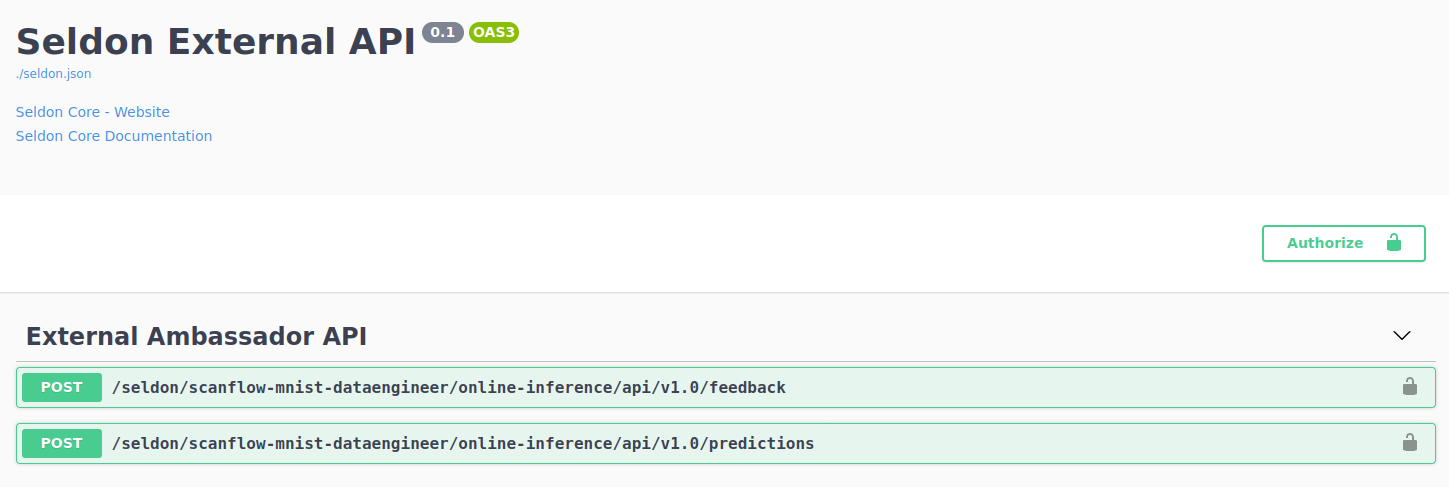

In [50]:
from IPython.display import Image
Image("/gpfs/bsc_home/xpliu/pv/jupyterhubpeini/scanflow/images/seldon-api.PNG", width=1200, height=400)

 
[online-inference] http://172.30.0.53:40000/seldon/scanflow-mnist-dataengineer/online-inference/api/v1.0/doc/#/
  

In [15]:
await deployerClient.delete_workflow(app_name='mnist', 
                                  team_name='dataengineer',
                                  workflow = build_app.workflows[1])

True


  
### Step8: Clean scanflow environment
  
  1. delete environment
  

In [19]:
await deployerClient.clean_environment(app=build_app)

15-Sep-21 15:25:02 -  INFO - [++] Stopping tracker: [scanflow-tracker].
15-Sep-21 15:25:02 -  ERROR - delete_deployment error
15-Sep-21 15:25:02 -  ERROR - delete_service error
15-Sep-21 15:25:02 -  INFO - [++]Delete tracker configmap scanflow-tracker-env
15-Sep-21 15:25:02 -  ERROR - delete_configmap error
15-Sep-21 15:25:02 -  INFO - [++]Delete client configmap scanflow-client-env
15-Sep-21 15:25:02 -  ERROR - delete_configmap error
15-Sep-21 15:25:02 -  INFO - [++]Delete s3 secret scanflow-secret
15-Sep-21 15:25:02 -  ERROR - delete_secret error
15-Sep-21 15:25:02 -  INFO - [++]Delete rolebinding default-admin
15-Sep-21 15:25:02 -  ERROR - delete_rolebinding error
15-Sep-21 15:25:02 -  INFO - [++]Delete namespace "scanflow-mnist-dataengineer"
15-Sep-21 15:25:02 -  INFO - delete_namespace true
15-Sep-21 15:25:02 -  ERROR - delete_pvc error
15-Sep-21 15:25:02 -  ERROR - delete_pv error


False